# Density Ratio Estimation Experiment 

In this article, we test whether the proposed LLLR can help a neural network estimating the true log-likelihood ratio. The inputs and networks are simplified to multidimensional Gaussian random variables and a 3-layer fully-connected network with nonlinear activation, respectively.

### Tested environment: tensorflow 2.0.0

In [1]:
from __future__ import absolute_import, division, print_function
import datetime, sys
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, uniform
from utils.misc import load_yaml, set_gpu_devices, fix_random_seed
from utils.util_tensorboard import TensorboardLogger
from utils.util_ckpt import checkpoint_logger
from models.backbones_DRE import MLP4DRE
from models.optimizers import get_optimizer
from models.losses import get_gradient_DRE

In [2]:
# load parameters
config_path = '/raid6/ebihara/python/SPRTproject/Density_Estimation_with_LLLR/config/config_LLLR.yaml'
config = load_yaml(config_path)

data_dim = config['data_dim']
density_offset = config['density_offset']
batch_size = config['batch_size']

# GPU settings
set_gpu_devices(config["gpu"])

# Set Random Seeds (Optional)
fix_random_seed(flag_seed=config["flag_seed"], seed=config["seed"])

Random seed not fixed.


## Experiment Settings
Our experimental settings are based on Sugiyama et al. 2008, "Direct importance estimation for covariate shift adaptation":

Let $p_0(x)$ be the $d$-dimensional Gaussian density with mean $(a, 0, 0, ..., 0)$ and covariance identity, and $p_1(x)$ be the $d$-dimensional Gaussian density with mean $(0, a, 0, ..., 0)$ and covariance identity. 

The task for the neural network is to estimate the density ratio:

$\hat{r}(x) = \frac{\hat{p}_1(x)}{\hat{p}_0(x)}$.

Here, $x$ is sampled either from $p_0$ or $p_1$. We compared 3 loss functions: (1) KLIEP, (2) LLLR, and (3) cross-entropy loss.

In [3]:
# for train logs
def tblog_writer(tblogger, losses, eval_metrics, global_step, phase):
    # Losses
    tblogger.scalar_summary("{}_loss/Sum_loss".format(phase), 
        losses[1] + losses[2] + losses[3], int(global_step))
    tblogger.scalar_summary("{}_loss/CE_loss".format(phase),
        losses[1], int(global_step))
    tblogger.scalar_summary("{}_loss/LLLR".format(phase), 
        losses[2], int(global_step))
    tblogger.scalar_summary("{}_loss/KLIEP".format(phase), 
        losses[3], int(global_step))

    # results of density-ratio estimation
    # Normalized Mean Squared Error (NMSE)
    tblogger.scalar_summary("{}_metric/LR_NMSE".format(phase), 
        eval_metrics[0], int(global_step))
    tblogger.scalar_summary("{}_metric/LLR_NMSE".format(phase), 
        eval_metrics[1], int(global_step))
    # Mean Absolute Error (MABS)
    tblogger.scalar_summary("{}_metric/LR_MABS".format(phase), 
        eval_metrics[2], int(global_step))    
    tblogger.scalar_summary("{}_metric/LLR_MABS".format(phase), 
        eval_metrics[3], int(global_step))


In [4]:
def LLR(x, pdf0, pdf1):
    LLRs = np.log(pdf1.pdf(x) / pdf0.pdf(x))
    LRs = pdf1.pdf(x) / pdf0.pdf(x)
    return LLRs, LRs

def generate_data(mean1, mean2, covmat, batch_size):
    # sample from p1 and p2
    x0 = np.random.multivariate_normal(mean1, covmat, batch_size//2).astype('float32')
    x1 = np.random.multivariate_normal(mean2, covmat, batch_size//2).astype('float32')
    
    y0 = np.zeros((batch_size//2))
    y1 = np.ones((batch_size//2))
    
    pdf0 = multivariate_normal(mean1, covmat)
    pdf1 = multivariate_normal(mean2, covmat)
    
    LLR0, LR0 = LLR(x0, pdf0, pdf1)
    LLR1, LR1 = LLR(x1, pdf0, pdf1)
    
    X = np.concatenate((x0, x1), axis=0)
    Y = np.concatenate((y0, y1), axis=0)
    
    LLRs = np.concatenate((LLR0, LLR1), axis=0)
    LRs = np.concatenate((LR0, LR1), axis=0)
    
    return X, Y, LLRs, LRs
    
    
# create the two probability density functions.
covmat = np.eye(data_dim)
mean0 = np.zeros((data_dim))
mean0[0] = density_offset
mean1 = np.zeros((data_dim))
mean1[1] = density_offset

pdf0 = multivariate_normal(mean0, covmat)
pdf1 = multivariate_normal(mean1, covmat)

# sample from p1 and p2
x0 = np.random.multivariate_normal(mean0, covmat, batch_size//2).astype('float32')
x1 = np.random.multivariate_normal(mean1, covmat, batch_size//2).astype('float32')

LLR0 = LLR(x0, pdf0, pdf1)
LLR1 = LLR(x1, pdf0, pdf1)


/home/FACE/ebihara/.local/lib/python3.5/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


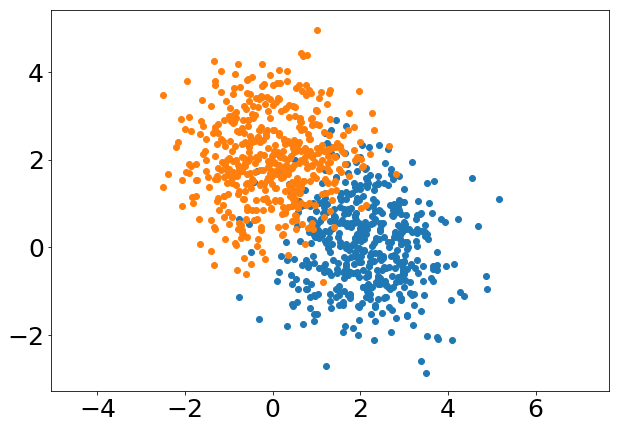

In [5]:
# visualize the first two dimensions of x1/x2
fig = plt.figure(figsize=(10,7))
fig.patch.set_facecolor('white')
plt.rcParams['font.size'] = 25
plt.scatter(x0[:, 0], x0[:, 1])
plt.scatter(x1[:, 0], x1[:, 1])
plt.axes().set_aspect('equal', 'datalim')
plt.show()

In [6]:
# model = MLP4DRE(
#     nb_cls=config["num_classes"], 
#     feat_dim=data_dim)
# epoch = 0
# x_batch, y_batch, GT_LLRs = generate_data(mean0, mean1, covmat, batch_size)

# # Show summary of model
# if epoch == 0:
#     model.build(input_shape=x_batch.shape)
#     model.summary() 
    
# outputs = model.call(
#     inputs=x_batch,
#     training=False)

# a = np.array([[1.0, 0.0, 0.0], [0.0, 0.8, 0.2]])
# a.shape

# labels = tf.convert_to_tensor(np.array([[1.0, 0.0, 0.0], [0.0, 0.8, 0.2]]).astype('float32'))
# logits = tf.convert_to_tensor(np.array([[4.0, 2.0, 1.0], [0.0, 5.0, 1.0]]).astype('float32'))
# tf.nn.softmax_cross_entropy_with_logits(labels, logits)

# # tf.convert_to_tensor(y_batch)
# # tf.one_hot(tf.convert_to_tensor(y_batch), depth=2)
# print(tf.compat.v1.losses.softmax_cross_entropy(tf.one_hot(y_batch.astype('int'), 2), outputs))
# print(tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(tf.one_hot(y_batch.astype('int'), 2), outputs)))

# LLR = outputs[:, 1] - outputs[:, 0]
# class0 = LLR[LLR.shape[0] // 2:]
# class1 = LLR[:LLR.shape[0] // 2]

# y_batch - tf.math.sigmoid(LLR)
# tf.reduce_mean((y_batch * -2 + 1) * tf.math.sigmoid(LLR))
# x_batch, y_batch, GT_LLRs, GT_LRs = generate_data(mean0, mean1, covmat, batch_size)
# model.build(input_shape=x_batch.shape)
# model.summary() 
# grads, losses, logits = get_gradient_DRE(
#             model, 
#             x_batch, 
#             y_batch, 
#             training=True, 
#             flag_wd=flag_wd_in_loss,
#             calc_grad=True,
#             param_CE_loss=config["param_CE_loss"], 
#             param_LLR_loss=config["param_LLR_loss"], 
#             param_KLIEP_loss=config['param_KLIEP_loss'],
#             param_wd=config["weight_decay"]
#             )

In [6]:
now = datetime.datetime.now().strftime("%Y%m%d_%H%M%S%f")[:-3]

# setup the network
model = MLP4DRE(
    nb_cls=config["num_classes"], 
    feat_dim=data_dim)

# setup the optimizer
optimizer, flag_wd_in_loss = get_optimizer(
    learning_rates=config["learning_rates"], 
    decay_steps=config["lr_decay_steps"], 
    name_optimizer=config["name_optimizer"], 
    flag_wd=config["flag_wd"], 
    weight_decay=config["weight_decay"])        

# Tensorboard and checkpoints
####################################
# Define global step
global_step = tf.Variable(0, name="global_step", dtype=tf.int32)

# Checkpoint
_, ckpt_manager = checkpoint_logger(
    global_step, 
    model, 
    optimizer, 
    config["flag_resume"], 
    config["root_ckptlogs"], 
    config["subproject_name"], 
    config["exp_phase"],
    config["comment"], 
    now, 
    config["path_resume"], 
    config["max_to_keep"],
    config_path)

# Tensorboard
#tf.summary.experimental.set_step(global_step)
tblogger = TensorboardLogger(
    root_tblogs=config["root_tblogs"], 
    subproject_name=config["subproject_name"], 
    exp_phase=config["exp_phase"], 
    comment=config["comment"], 
    time_stamp=now)

Set Tensorboard drectory:  /raid6/ebihara/tensorflow/logs/LLLR_toymodel/tblogs/LLLR_v2_stat/LLLR_20201106_135132336


In [7]:
# eval_metrics = calc_NMSE_MABS(GT_LLRs, logits)
def calc_NMSE_MABS(GT_LRs, GT_LLRs, logits):
    estimated_LRs = tf.nn.softmax(logits).numpy()
    estimated_LRs = estimated_LRs[:, 1] / estimated_LRs[:, 0]
    
    estimated_LLRs = (logits[:, 1] - logits[:, 0]).numpy()
    
    LR_NMSE = np.mean((GT_LRs / np.sum(GT_LRs) - estimated_LRs / np.sum(estimated_LRs))**2)
    LLR_NMSE = np.mean((GT_LLRs / np.sum(GT_LLRs) - estimated_LLRs / np.sum(estimated_LLRs))**2)
    
    LR_MABS = np.mean(np.abs(GT_LRs, estimated_LRs))
    LLR_MABS = np.mean(np.abs(GT_LLRs, estimated_LLRs))
    
    return LR_NMSE, LLR_NMSE, LR_MABS, LLR_MABS



In [8]:
x_batch, labels, GT_LLRs, GT_LRs = generate_data(mean0, mean1, covmat, batch_size)
logits = model(x_batch, True)

LLR_estimated = logits[:, 1] - logits[:, 0]
KLIEP = tf.reduce_mean(((labels * -2) + 1) * LLR_estimated)

LR = tf.nn.softmax(logits)


In [13]:
x_batch, y_batch, GT_LLRs, GT_LRs = generate_data(mean0, mean1, covmat, batch_size)

# Show summary of model
model.build(input_shape=x_batch.shape)
model.summary() 

# Calc loss and grad, and backpropagation
grads, losses, logits = get_gradient_DRE(
    model, 
    x_batch, 
    y_batch, 
    training=True, 
    flag_wd=flag_wd_in_loss,
    calc_grad=True,
    param_CE_loss=config["param_CE_loss"], 
    param_LLR_loss=config["param_LLR_loss"], 
    param_LLLR_v2=config["param_LLLR_v2"], 
    param_KLIEP_loss=config['param_KLIEP_loss'],
    param_wd=config["weight_decay"]
    )

optimizer.apply_gradients(zip(grads, model.trainable_variables))
LR_NMSE, LLR_NMSE, LR_MABS, LLR_MABS = calc_NMSE_MABS(GT_LRs, GT_LLRs, logits)

estimated_LRs = tf.nn.softmax(logits).numpy()
estimated_LRs = estimated_LRs[:, 1] / estimated_LRs[:, 0]

Model: "MLP4DRE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo multiple                  400       
_________________________________________________________________
activation (Activation)      multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  10000     
_________________________________________________________________
dense_1 (Dense)              multiple                  10000     
_________________________________________________________________
dense_2 (Dense)              multiple                  200       
Total params: 20,600
Trainable params: 20,400
Non-trainable params: 200
_________________________________________________________________


In [17]:
GT_LRs

array([3.12708228e+01, 1.94083640e-02, 9.28047549e+00, 3.25609679e-02,
       5.12978444e-04, 1.22459994e-03, 7.59624365e-02, 2.40196551e-03,
       1.41960444e-02, 4.97887820e-03, 1.13219545e+00, 4.68973323e-02,
       1.51384052e-01, 9.15506931e-03, 9.25550351e-03, 1.25581112e-03,
       6.76498263e-05, 1.21148047e-04, 1.33572628e-01, 6.12671445e-05,
       1.09626442e-01, 4.21285012e-01, 2.50143717e-01, 2.47541479e-03,
       2.53212916e-02, 7.97697264e-03, 3.54311611e-02, 1.06648400e-03,
       1.89102068e-02, 8.15205285e-05, 1.57757073e-01, 6.59701398e-02,
       2.08825423e-02, 4.09342701e-02, 1.50275642e-01, 2.91072397e-03,
       2.43569422e-01, 4.96443845e-03, 8.15984342e-02, 4.55870506e-04,
       2.01495265e-01, 1.36696799e-01, 1.60149415e-02, 6.49076172e-01,
       2.60145776e-04, 1.21758556e+00, 1.01245451e-01, 1.37096066e+00,
       5.94024017e-05, 8.36260806e-04, 2.80084503e-02, 5.64863131e-02,
       2.63292279e-01, 2.39942583e-04, 7.09564110e-03, 4.58069638e-03,
      

In [31]:
# Training
####################################
# Start training
with tblogger.writer.as_default():
    # Initialization    
    estimation_error_pool = np.zeros((config['num_iter'], 2)) # 2 metrics: NMSE and MABS
    
    for epoch in range(config['num_iter']):
        # Training loop   
        x_batch, y_batch, GT_LLRs, GT_LRs = generate_data(mean0, mean1, covmat, batch_size)

        # Show summary of model
        if epoch == 0:
            model.build(input_shape=x_batch.shape)
            model.summary() 

        # Calc loss and grad, and backpropagation
        grads, losses, logits = get_gradient_DRE(
            model, 
            x_batch, 
            y_batch, 
            training=True, 
            flag_wd=flag_wd_in_loss,
            calc_grad=True,
            param_CE_loss=config["param_CE_loss"], 
            param_LLR_loss=config["param_LLR_loss"], 
            param_KLIEP_loss=config['param_KLIEP_loss'],
            param_wd=config["weight_decay"]
            )

        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        LR_NMSE, LLR_NMSE, LR_MABS, LLR_MABS = calc_NMSE_MABS(GT_LRs, GT_LLRs, logits)
        global_step.assign_add(1)

        # train log
        if tf.equal(global_step % config['train_display_step'], 0) or tf.equal(global_step, 1):
            print('Global Step={:7d}/{:7d}'.format(int(global_step), config['num_iter']))
            print('CE loss:{:7.5f} * {}'.format(losses[1], str(config['param_CE_loss'])))
            print('LLLR :{:7.5f} * {}'.format(losses[2], str(config['param_LLR_loss']))) # I know it's redandunt
            print('KLIEP loss:{:7.5f} * {}'.format(losses[3], str(config['param_KLIEP_loss'])))
                  
            # Tensorboard
            tblog_writer(
                tblogger,
                losses, 
                [LR_NMSE, LLR_NMSE, LR_MABS, LLR_MABS],
                global_step,
                phase='train')
        
        # validation
        if tf.equal(global_step % config['validation_step'], 0) or tf.equal(global_step, 1):

            x_batch, y_batch, GT_LLRs, GT_LRs = generate_data(mean0, mean1, covmat, batch_size)
            # Calc loss and grad, and backpropagation
            _, losses, logits = get_gradient_DRE(
                model, 
                x_batch, 
                y_batch, 
                training=False, 
                flag_wd=flag_wd_in_loss,
                calc_grad=False,
                param_CE_loss=config["param_CE_loss"], 
                param_LLR_loss=config["param_LLR_loss"], 
                param_KLIEP_loss=config['param_KLIEP_loss'],
                param_wd=config["weight_decay"]
                )
            
            LR_NMSE, LLR_NMSE, LR_MABS, LLR_MABS = calc_NMSE_MABS(GT_LRs, GT_LLRs, logits)
            
            if tf.equal(global_step, 1):
                best = LLR_NMSE
            
            # Tensorboard
            tblog_writer(
                tblogger,
                losses, 
                [LR_NMSE, LLR_NMSE, LR_MABS, LLR_MABS],
                global_step,
                phase='validation')
            
            # Save checkpoint
            if best > LLR_NMSE and int(global_step) > 1:
                best = LLR_NMSE
                
                ckpt_manager._checkpoint_prefix = \
                            ckpt_manager._checkpoint_prefix[:ckpt_manager._checkpoint_prefix.rfind("/") + 1] + \
                            "ckpt_step{}_LLR_NMSE{:.5f}".format(int(global_step), best)
                save_path_prefix = ckpt_manager.save()
                print("Best value updated. Saved checkpoint for step {}: {}".format(
                    int(global_step), save_path_prefix))


Model: "MLP4DRE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_3 (Batch multiple                  400       
_________________________________________________________________
activation_3 (Activation)    multiple                  0         
_________________________________________________________________
dense_9 (Dense)              multiple                  10000     
_________________________________________________________________
dense_10 (Dense)             multiple                  10000     
_________________________________________________________________
dense_11 (Dense)             multiple                  200       
Total params: 20,600
Trainable params: 20,400
Non-trainable params: 200
_________________________________________________________________
Global Step=      1/ 100000
CE loss:0.89139 * 0.0
LLLR :0.49849 * 1.0
KLIEP loss:-0.03423 * 0.0
Global Step=   1000/ 10

KeyboardInterrupt: 

In [38]:
LLR_NMSE

0.02046899827512428